In [4]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

In [5]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi'] # Will need to use more features

financial_features = ['salary', 'deferral_payments', 'total_payments', 'bonus', 'restricted_stock',\
                      'restricted_stock_deferred', 'total_stock_value', 'director_fees', 'deferred_income',\
                      'expenses', 'loan_advances', 'exercised_stock_options', 'other',\
                      'long_term_incentive']

email_features = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',\
                  'shared_receipt_with_poi']

all_features = ['poi', 'email_address', 'salary', 'to_messages', 'deferral_payments',\
                'total_payments','exercised_stock_options', 'bonus', 'restricted_stock',\
                'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value',\
                'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi',\
                'director_fees', 'deferred_income','long_term_incentive', 'from_poi_to_this_person']


In [51]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [52]:
### Task 2: Remove outliers

tot_data_points = len(data_dict)
tot_features = len(data_dict[data_dict.keys()[0]])
tot_poi = 0
for d in data_dict.values():
    if d['poi'] == 1:
        tot_poi += 1

print "Total number of Data points are ", tot_data_points
print "Total number of Features are ", tot_features
print "Total number of POIs are ", tot_poi

Total number of Data points are  146
Total number of Features are  21
Total number of POIs are  18


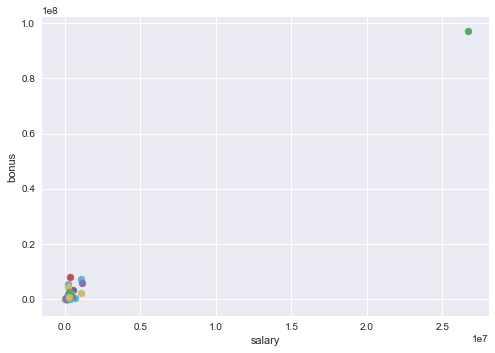

In [53]:
features = ["salary", "bonus"]

data = featureFormat(data_dict, features)

# plot salary vs bonus

for point in data:
    salary = point[0]
    bonus = point[1]
    plt.scatter( salary, bonus )

plt.xlabel("salary")
plt.ylabel("bonus")
plt.show()

In [54]:
# Remove 'TOTAL'
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.drop('TOTAL')

In [55]:
# deal with NaNs
df = df.replace('NaN', np.nan)

# Replace NaNs of financial feature with 0
df[financial_features] = df[financial_features].fillna(0)

# Replace NaNs of email feature with it's median
df[email_features] = df[email_features].fillna(df[email_features].median())

In [40]:
# who are those outlier records
email_outliers = df[np.logical_or(df.from_messages > 6000, df.to_messages > 10000)]
print(email_outliers)

                       salary  to_messages  deferral_payments  total_payments  \
KAMINSKI WINCENTY J  275101.0       4607.0                0.0       1086821.0   
KEAN STEVEN J        404338.0      12754.0                0.0       1747522.0   
SHAPIRO RICHARD S    269076.0      15149.0                0.0       1057548.0   

                     exercised_stock_options      bonus  restricted_stock  \
KAMINSKI WINCENTY J                 850010.0   400000.0          126027.0   
KEAN STEVEN J                      2022048.0  1000000.0         4131594.0   
SHAPIRO RICHARD S                   607837.0   650000.0          379164.0   

                     shared_receipt_with_poi  restricted_stock_deferred  \
KAMINSKI WINCENTY J                    583.0                        0.0   
KEAN STEVEN J                         3639.0                        0.0   
SHAPIRO RICHARD S                     4527.0                        0.0   

                     total_stock_value           ...            l

In [56]:
#Remove the outlier records(records which are not characteristic of a typical employee)

df = df[df.from_messages < 6000]
df = df[df.to_messages < 10000]


In [57]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
df['fraction_to_poi'] = df.from_this_person_to_poi / df.from_messages
df['fraction_from_poi'] = df.from_poi_to_this_person / df.to_messages

my_dataset = df.to_dict('index')

In [58]:
### Extract features and labels from dataset for local testing
my_features_list = features_list + email_features + financial_features
updated_features_list = my_features_list + ['fraction_to_poi', 'fraction_from_poi']
data = featureFormat(my_dataset, updated_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [59]:
# Scale the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

Best features:
[('exercised_stock_options', 24.740741755486567), ('total_stock_value', 24.376824998085763), ('bonus', 20.983121489541126), ('salary', 19.451967509669792), ('fraction_to_poi', 12.271728536115715), ('deferred_income', 11.321486775141773), ('shared_receipt_with_poi', 10.388901632115788), ('long_term_incentive', 9.936044522585096), ('restricted_stock', 9.7342175020536441), ('total_payments', 8.744374917030548), ('expenses', 7.1997829085576326), ('loan_advances', 7.1253824688830658), ('from_poi_to_this_person', 4.5182065211382376), ('to_messages', 4.0999157444317822), ('other', 4.0886658318595988), ('from_this_person_to_poi', 3.5564006211527417), ('director_fees', 2.1453342495720524), ('fraction_from_poi', 1.5164456158569719), ('deferral_payments', 0.23236805825462264), ('restricted_stock_deferred', 0.066023245366865962), ('from_messages', 0.010020814293397391)]


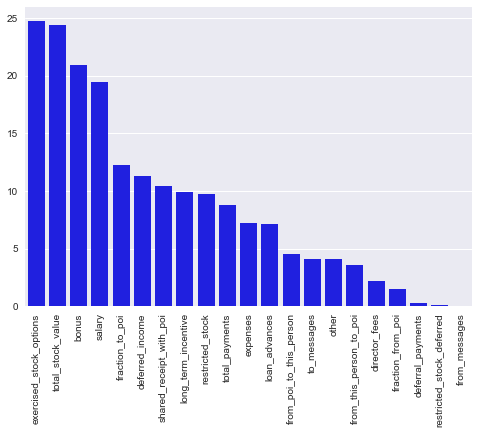

['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary']


In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
k=4
selecter = SelectKBest(f_classif, k)
selecter.fit_transform(features, labels)
print("Best features:")
sc = zip(updated_features_list[1:],selecter.scores_)
sorted_sc = sorted(sc, key = lambda x: x[1], reverse=True)
print sorted_sc
xvals = list()
yvals = list()
for i in range(len(sorted_sc)):
    xvals.append(sorted_sc[i][0])
    yvals.append(sorted_sc[i][1])
sns_obj = sns.barplot(x=xvals,y=yvals,color='blue')
for item in sns_obj.get_xticklabels():
    item.set_rotation(90)
plt.show()

fab_four_with_poi = ['poi'] + list(map(lambda x: x[0], sorted_sc))[0:k]
print(fab_four_with_poi)

In [61]:
data = featureFormat(my_dataset, fab_four_with_poi, sort_keys = True)
labels, features = targetFeatureSplit(data)

data_with_new = featureFormat(my_dataset, fab_four_with_poi + ['fraction_to_poi', 'fraction_from_poi'], sort_keys = True)
labels_new, features_new = targetFeatureSplit(data_with_new)
features_new = scaler.fit_transform(features_new)

In [49]:
from sklearn import naive_bayes    
from sklearn.grid_search import GridSearchCV
nb_clf = naive_bayes.GaussianNB()
nb_param = {}
nb_grid_search = GridSearchCV(nb_clf, nb_param)
print("Evaluate naive bayes model")
test_classifier(nb_clf, my_dataset, fab_four_with_poi)
print("Evaluate naive bayes model with added features:")
test_classifier(nb_clf, my_dataset, fab_four_with_poi + ['fraction_to_poi', 'fraction_from_poi'])
#Evaluate naive bayes model
#Accuracy: 0.84908
#Precision: 0.51464
#Recall: 0.33400
#Evaluate naive bayes model with added features:
#Accuracy: 0.85173
#Precision: 0.42884
#Recall: 0.33750

#from sklearn import linear_model
#from sklearn.pipeline import Pipeline
#from sklearn import preprocessing
#from sklearn.grid_search import GridSearchCV

#lo_clf = Pipeline(steps=[
#        ('scaler', preprocessing.StandardScaler()),
#        ('classifier', linear_model.LogisticRegression())])
       
#lo_param = {'classifier__tol': [1, 0.1, 0.01, 0.001, 0.0001], \
#            'classifier__C': [0.1, 0.01, 0.001, 0.0001]}
#lo_grid_search = GridSearchCV(lo_clf, lo_param)
#print("Evaluate logistic regression model")
#test_classifier(lo_grid_search, my_dataset, fab_four_with_poi)
#print 'Best parameters:'
#print lo_grid_search.best_params_
#eval_clf(lo_grid_search, features, labels, lo_param)
#Accuracy: 0.85000
#Precision: 0.53894
#Recall: 0.17300
#Best parameters
#{'classifier__C': 0.01, 'classifier__tol': 1}

#from sklearn import tree
#dt_clf = tree.DecisionTreeClassifier()
#parameters = {'criterion': ['gini', 'entropy'],
#               'min_samples_split': [2, 10, 20],
#               'max_depth': [None, 2, 5, 10],
#               'min_samples_leaf': [1, 5, 10],
#               'max_leaf_nodes': [None, 5, 10, 20]}
#grid_search = GridSearchCV(dt_clf, parameters)
#print("Evaluate Decision Tree model")
#test_classifier(grid_search, my_dataset, fab_four_with_poi)
#print 'Feature importances:'
#print grid_search.feature_importances_
#print 'Best parameters:'
#print grid_search.best_params_
#Accuracy: 0.81923
#Precision: 0.12446
#Recall: 0.02900
#Best parameters
#{'min_samples_split': 2, 'max_leaf_nodes': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}


#from sklearn.ensemble import AdaBoostClassifier
#clf = AdaBoostClassifier()
#parameters = {'n_estimators': [10, 20, 30, 40, 50],
#              'algorithm': ['SAMME', 'SAMME.R'],
#              'learning_rate': [.5,.8, 1, 1.2, 1.5]}
#grid_search = GridSearchCV(clf, parameters)
#print("Evaluate AdaBoost model")
#test_classifier(grid_search, my_dataset, fab_four_with_poi)
#print 'Best parameters:'
#print grid_search.best_params_
#Accuracy: 0.83023
#Precision: 0.37979
#Recall: 0.16350
#Best parameters:
#{'n_estimators': 10, 'learning_rate': 1, 'algorithm': 'SAMME'}


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

Evaluate naive bayes model
GaussianNB(priors=None)
	Accuracy: 0.84908	Precision: 0.51464	Recall: 0.33400	F1: 0.40509	F2: 0.35922
	Total predictions: 13000	True positives:  668	False positives:  630	False negatives: 1332	True negatives: 10370

Evaluate naive bayes model with added features:
GaussianNB(priors=None)
	Accuracy: 0.85173	Precision: 0.42884	Recall: 0.33750	F1: 0.37773	F2: 0.35252
	Total predictions: 15000	True positives:  675	False positives:  899	False negatives: 1325	True negatives: 12101



In [63]:
from sklearn import naive_bayes
clf = naive_bayes.GaussianNB()
final_features_list = fab_four_with_poi + ['fraction_to_poi', 'fraction_from_poi']


### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(clf, my_dataset, final_features_list)